# Data analysis with SciAnalysis

last updated: 2022 Nov 3

### Section A: SciAnalysis

- A1. <span style='background :yellow' > __Tutorial to SciAnalysis__</span> (stadard routines: circular_average, qr_image, etc): If you are not familiar with SciAnalysis, go through Section A1 carefully, this will help you understand the code and run the routine data reduction/analysis. 
<span style='background :yellow' > __Note__</span> that the parameters in this jupyter notebook might not be correct for your experiment, check your data and runXS.py file. If you are comfortable with python, you should run the runXS.py (in the analysis folder) file directly.
- A2. Stitching SAXS or WAXS raw data
- A3. Background subtraction  
- A4. Adjust fitting: load DAT file and fit
- A5. Load results and plot: Load 2D, XM (roi, fitting result)

### Section B: Experiment (RHeadrick3)

- B1. Define an 'experiment': for comparimg multiple measuremeants e.g. mapping
- B2. Plot


--------------------------------------

# &#9635; Section A: SciAnalysis

## &#9632; A1. Tutorial to SciAnalysis

Load raw data (TIFF) and do analysis

### A1.1 Download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis

### A1.2 Put your download path for SciAnalysis_PATH:

In [ ]:
#%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio

#SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols


### A1.3. Specify beamline parameters 

Specify parameters based on SAXS/WAXS and beamline configuration.

In [ ]:
# Experimental parameters
########################################
## CMS
if 1: ### RHeadrick3
    calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(473, 1043-387-15+11) #Headrick3, 2022 Oct 27, 17kev_normal_WAXSx-225_y22_z-142_x0.000_y0.000_10.00s_762645_waxs   
    
    calibration.set_distance(0.261)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')
    
if 0:
    # Custom Dectris Pilatus 800k (lower-left modules removed)
    calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(475, 1043-386) 

    calibration.set_distance(0.259)

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    mask = Mask(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png')

## SMI
if 0:
    calibration = Calibration(wavelength_A=0.770088) # 16.1 keV
    calibration.set_image_size(981, height=1043) 
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_distance(8.320) # 8.300 nominal detector distance

    ## With AgBH
    calibration.set_distance(8.300) # 8.300 nominal detector distance
    calibration.set_beam_position(492, 557) #2022 TSAXS, VS    ###Choose the one you need
    #calibration.set_beam_position(492, 557+145) #2022 GISAXS, HE   ###Choose the one you need

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus1M_main_gaps-mask.png')
    mask.load('./mask_badpixel3.png')

(Optional: If direct beam measurement is available, use that for the beam center, else use AgBH)

In [ ]:
#### If direct beam measurement is available, use that for the beam center, else use AgBH

EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/JChoi/saxs/'  
pattern = '*DirectBeam*'
infiles = glob.glob(os.path.join(EXPR_DIR+'raw/', pattern+'.tiff'))
print(infiles)

data = Data2DScattering()
data.load(infiles[0])
img = data.data
#img[0:400] = 0
#plt.figure(); plt.imshow(np.log10(img))
beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
print('Beam center = {}'.format(beam_center))

### A1.4. Specify data path and analysis parameters

Specify data directory (source_dir) and where you want to save the outputs (output_dir).

#### Use 'pattern' to specify the files you want to analyze. Can start with one specific file of interest to determine the analysis protocal and parameters (Sections A1.4 and A1.5), and then process all data.

Specify the analysis protocal to use, e.g.
- circular average integrate over the entire ring, and outputs Intensity vs. q in PNG and also in DAT
- sector_average(name = 'sector_average_angle60_d10', angle=60, dangle=10) outputs the integration over dangle 10deg, with center at angle 60 (twelve oclock is 0 degree, goes clock-wise, so 60deg is two olock direction). Outputs are stored under the folder 'sector_average_angle60_d10'. Changing the name can be useful if you want different sector_average analysis.
- See Readme in https://github.com/CFN-softbio/SciAnalysis


In [ ]:
# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/JHidalgo/waxs/'  ### CHANGE THIS
EXPR_DIR = '/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/waxs/'
source_dir = EXPR_DIR + 'raw/'   ### CHANGE THIS
output_dir = EXPR_DIR + 'analysis/'   ### CHANGE THIS

# patterns = ['*117840*','*117642*','*117644*','*117830*','*117832*'] ### CHANGE THIS
patterns = ['*B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434*'] ### CHANGE THIS


# Analysis to perform
########################################

load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : False,
             }
run_args = { 'verbosity' : 3,
            'fittype': 'voigt',
            }

run_args = { 'verbosity' : 3,
             'rcParams': {'axes.labelsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            'fittype': 'voigt',
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    #Protocols.calibration_check(show=False, AgBH=True, q0=0.1076, dq=0.005, num_rings=10, ztrim=[0.2, 0.01], dpi=300) ,
    #Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'
    
    #Protocols.qr_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,
    #Protocols.thumbnails(name='thumbnails_vgehdr', crop=None, resize=0.5, cmap=cmap_vge_hdr, ztrim=[0.02, 0.001]) , # Pilatus800k

    #Protocols.circular_average_q2I_fit(name='circular_fit_compare3', plot_range=[1.2, 1.8, -0.5, 2], qn_power=0.0, trim_range=[0.1, 3.5], fit_range=[1.4-0.04, 1.44+0.07], num_curves=1, q0=[1.415], sigma=0.02, gamma=0.02, show_curves=1, label_filename=True), 
   
    #Protocols.q_phi_image(bins_relative=0.25, plot_range=[0, 3.5, -90, +90],transparent=False),
    
    Protocols.roi(show_region=0, qx=0.5, dqx=0.02, qz=2.2, dqz=0.02, prepend='stats_'),
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], transparent=False, label_filename=True, plot_buffers = [0.2, 0.1, 0.2, 0.1]),
     
    ]

### A1.5. Apply analysis 

- Run this step to do the analysis. Repeat Sections A1.4 and A1.5 to adjust protocoal parameters and apply analysis.

- If force=1, it will do analysis and overwrite old analysis results. 

- If the last line (process.monitor_loop) is used, it will run real-time analysis, ie, it keeps on checking if there are new files in the source_dir to apply the analysis protocals, force=0 in this case to process only new data.

In [ ]:
# Run
########################################
t0 = time.time()

for pattern in patterns:   
    infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
    infiles.sort()    
    
    print('Processing {} infiles...'.format(len(infiles)))
    process.run(infiles, protocols, output_dir=output_dir, force = 1) ### CHANGE THIS: force=0 or 1

print('===== Process Time: {:.1f} min ====='.format((time.time()-t0)/60))


########################################
# This is typically only used at the beamline (it loops forever, watching for new files).
#process.monitor_loop(source_dir=source_dir, pattern='*.tiff', protocols=protocols, output_dir=output_dir, force=False)



## &#9632;  A2. Stitching 2D SAXS or WAXS 
 
#### Option 1. Current standard at the beamline: using Jupyter Notebook by RL 

1) Run ./software/StitchPilatus/stitch_2M.ipynb or stitch_800l.ipynb, this will output TIFF under ./stitched/

2) Run analysis (Section A1) using the stitched TIFF files instead of the ./raw/ ones. Change mask.


#### Option 2. Stitch files with SciAnalysis:
 
 1) run stitch.py to stitch into .TIFF (This stitched TIFF is larger than what's done in Option 1.)
 
 2) run runStitched.py to generate thumbnails etc

 ## &#9632;  A.3 Background subtraction 
 
 Same as Section A1, except we specify background in __load_args__:
 
 - 'background' can be (1) a raw TIFF, (2) one float value, or (3) an np.ndarray
 
 - 'transmission_int' can be (1) the transmission CSV file under ./data/, or (2) one float value
 

In [ ]:
# Experimental parameters
########################################
calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
#calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
calibration.set_image_size(1475, height=1679) # Pilatus2M
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(738.0, 1679-593 ) # SAXSx -60, SAXSy -73
#calibration.set_beam_position(738.0, 1679-563 ) # 8--12
calibration.set_distance(2.0) # 5m

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
mask.load(EXPR_DIR+'saxs/analysis/Pilatus2M_current-mask_Kap.png')

# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe/saxs/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/Exxon3/'

source_dir = EXPR_DIR + 'saxs/raw/'
output_dir = EXPR_DIR + 'saxs/analysis_test/'

pattern = 'MG*492830*'  

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()


# Analysis to perform
########################################
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'background' : '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe2/saxs/raw/'+'*0130*tiff',
             'background' : EXPR_DIR+'/saxs/raw/MG_empty_BKG_x0.000_y0.000_10.00s_492839_saxs.tiff',
             #'background' : 100,
             'transmission_int': EXPR_DIR+'/data/Transmission_output.csv', # Can also specify an float value, eg 1.4
             }

run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25, 
                         'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'   
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,     
    ]


# Run
########################################
t0 = time.time()

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
infiles.sort()    
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force = 1)

print('Process Time: {:.1f} min'.format((time.time()-t0)/60))


#---------
# process.load(infiles[0], **load_args)
# data = process.handle_calibration(infile, **load_args)
# process.handle_background(data, **load_args)


#### Show before/after background subtraction

In [ ]:
import imageio

## Load images
#filename = 'CKe_S5_24k_4vac_x0.100_y-0.200_20.00s_2790326_saxs'
filename = 'MG_19-110924-1_virgin_KapCap2mm_x-0.000_y0.000_10.00s_492830_saxs'

infile0 = output_dir+'q_image/' + filename + '.png'
infile1 = output_dir+'q_image/' + filename + '_rmbkg.png'
img0 = imageio.imread(infile0)
img1 = imageio.imread(infile1)


## Plot
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10] #[height, width] of the figure

plt.subplot(2,2,1)
plt.imshow(img0); plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(img1); plt.title('Background removed')

plt.show()


## Load 1D
infile0 = output_dir+'circular_average/' + filename + '.dat'
infile1 = output_dir+'circular_average/' + filename + '_rmbkg.dat'
line0 = np.loadtxt(infile0)
line1 = np.loadtxt(infile1)

## Plot
plt.subplot(2,2,3)
plt.plot(line0[:,0], np.log10(line0[:,2])); plt.grid()
plt.subplot(2,2,4)
plt.plot(line1[:,0], np.log10(line1[:,2])); plt.grid()

plt.show()


In [ ]:
import re, difflib
import pandas as pd

infile = EXPR_DIR+'/data/Transmission_output.csv'
df = pd.read_csv(infile)
#print(df)

filelist = df['b_scanID']

b = filelist.isin([492809])
print(b)


 ## &#9632;  A.4 Adjust fitting
 
- Option 1. Can be done directly on raw data by specifying the propotcal in Section A1, 
- Option 2. Run the following section to load a 1D curve and apply fitting.

In [ ]:
## Load one DAT infile to test and select fitting range
pattern = ''
infiles = glob.glob(os.path.join(output_dir+'/circular_average/', pattern+'*.dat')); 
infile = infiles[0]
if 0:  ## Load from analysis output .DAT
    line = DataLine(infile) 
else:  ## General loading
    data = np.loadtxt(infile)
    line = DataLine(x = data[:,0], y = data[:,2])

    
## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}

protocol = Protocols.fit_peaks()
lines = protocol._fit(line, results, **run_args, q0=[1, 2], num_curves=2, fit_range=[0.95, 2.5])


## Plot
#%matplotlib tk
#lines._plot_main(**plot_args)

for nn, line in enumerate(lines.lines):
    if nn==0: 
        plt.plot(line.x, line.y, 'b:', linewidth=1, label=line.name)
        plt.title(line.name)
    else:
        plt.plot(line.x, line.y, 'g', linewidth=2, label=line.name)
        
    plt.grid()
    
    
    ## Plot reference lines
    xs = [0.7, 1.8]
    for x in xs:
        plt.axvline(x, color='r', dashes=[3,3])
        
    
    ## Plot range
    plt.xlim([0.4, 2.5])
    

        
plt.show()

#lines._plot_main()
#lines._plot_extra()

# from SciAnalysis.CurveAnalysis.Data import *
# line = DataLineStructuredSort(infile)
# lines = line.fit_peaks(line, num_curves=1, **run_args)


## &#9632;  A.5 Load results and plot
### &#9632;  A5.1 Load 2D in q

In [ ]:
#%matplotlib nbagg

#output_dir = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/waxs/analysis/'
output_dir = '/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/waxs/analysis/'
infile = output_dir+'q_image/B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434_waxs.npz'
print(infile)

data = np.load(infile)
#print(list(data))

image = data['image']
x_axis = data['x_axis']
y_axis = data['y_axis']
x_scale = data['x_scale']
y_scale = data['y_scale']


##### Can plot in log or not; Adjust cmap for colormap, clim for plot range
plt.figure(); 
plt.pcolormesh(x_axis, y_axis, np.log(image), cmap='viridis') #plot in log intensity

plt.colorbar()
plt.clim([0, 6])

[qx, qz] = [0.48, 2.175]
[dqx, dqz] = [0.02, 0.02]
plt.plot([qx-dqx, qx+dqx], [qz-dqz, qz-dqz], 'r-')
plt.plot([qx-dqx, qx+dqx], [qz+dqz, qz+dqz], 'r-')
plt.plot([qx-dqx, qx-dqx], [qz-dqz, qz+dqz], 'r-')
plt.plot([qx+dqx, qx+dqx], [qz-dqz, qz+dqz], 'r-')

print([qx, qz] /x_scale)
plt.title(infile)

### &#9632;  A5.2 Extract analysis results from .XML to .TXT and .NPY
 
 E.g. fitting parameters (output from runX.py) are saved in ./analysis/results/*.xml
 
 For one or multiple measurements, this script load the .XML and save it to .TXT and .NPY

In [ ]:
## Functions for extracting results from xml files
########################################
from SciAnalysis.Result import * # Results() object
def extract_results(infiles, extractions, outfile, verbosity=3):
    if verbosity>=3: print("Extracting results for {} infiles...".format(len(infiles)))   
    results = Results().extract_multi_save_txt(outfile, infiles, extractions, verbosity=verbosity)
    
    return results

def load_file(infile, verbosity=3):
    if verbosity>=3:
        print(" Loading data from file: {}".format(infile))
    
    with open(infile, 'r') as fin:
        names = fin.readline().split()
        lines = fin.readlines()

    if verbosity>=4:
        print('  Saved data has {} columns:'.format(len(names)))
        print(names)
        
    return names, lines


# Files to analyze
########################################
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/'
verbosity = 3

source_dir = EXPR_DIR + 'stitched_analysis_test/'
output_dir = EXPR_DIR + 'stitched_analysis_test/'

pattern = 'NT' 

## Extract results from XML files
results_dir = source_dir + 'results/' # Location of xml files
infiles = glob.glob(os.path.join(results_dir, '{}*.xml'.format(pattern)))
outfile = os.path.join(output_dir, '{}-extracted.txt'.format(pattern))


extractions = [ #[ 'metadata_extract', ['x_position', 'y_position', 'sequence_ID', 'anneal_time'] ] ,
            ['circular_fit_compare3', ['fit_peaks_prefactor1', 'fit_peaks_x_center1', 'fit_peaks_sigma1', 'fit_peaks_chi_squared', 'fit_peaks_d0', 'fit_peaks_grain_size' ] ],
            ]    

results = extract_results(infiles, extractions, outfile=outfile, verbosity=verbosity)


## Export results of interest to an array
names, lines = load_file(outfile, verbosity=verbosity)

columns = [
    #'metadata_extract__x_position', 
    #'metadata_extract__y_position', 
    #'metadata_extract__anneal_time',
    'circular_fit_compare3__fit_peaks_chi_squared'
    ]

indices = [names.index(col) for col in columns]

data = []
for i, line in enumerate(lines):
    line = line.split()
    if len(line)>=len(indices):
        row = [ float(line[i]) for i in indices ]
        data.append(row)

print('\n----- Output array:\n {}'.format(data))
        
## Save 
if 0: 
    outfile = os.path.join(output_dir, '{}-{:d}.npy'.format(pattern, len(data)))
    np.save(outfile, data)
    if verbosity>=3:
        print('  Saved data as'.format(outfile))

        
    

### &#9632;  A5.3 Load ROI

In [ ]:
import pandas as pd

## Get infile
#pattern = 'B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs'
pattern = 'B6_N3_Trans3_map_vac_x-1.410_y-1.050_2.00s_763434'
infiles = glob.glob(os.path.join(output_dir+'/roi/', pattern+'*.txt')); 
print('Plotting {} infiles...'.format(len(infiles)))

## Load 
stats_list = []
for nn, infile in enumerate(infiles):
    data =  pd.read_table(infile, delimiter = ' ', header=None)
    if nn==0: print(data)
        
    temp = []
    for ii in np.arange(3,13):
        temp.append(data[2][ii])
    stats_list.append(temp)

    
stats_array = np.asarray(stats_list)


## Plot 
#%matplotlib tk
plt.rcParams['figure.figsize'] = [10, 5] #[height, width] of the figure

for ii in np.arange(0,stats_array.shape[1]):
    plt.plot(stats_array[:,ii])


## &#9632; A.6 Run analysis on a raw file directly

In [ ]:
#%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
#SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

if 1: 
    calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(473, 1043-387-15+11) #Headrick3, 2022 Oct 27, 17kev_normal_WAXSx-225_y22_z-142_x0.000_y0.000_10.00s_762645_waxs   
    
    calibration.set_distance(0.261)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')

In [ ]:
## Load one DAT infile to test and select fitting range
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/waxs/raw/'

pattern = 'B5_BPET_R2_1_vac'
infiles = glob.glob(os.path.join(EXPR_DIR, pattern+'*.tiff')); 
print('Len = {}'.format(len(infiles)))
infile = infiles[0]

output_dir = './'

In [ ]:
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

line_sector = []
for infile in infiles:
    data = process.load(infiles[0], calibration=calibration, mask=mask, run_args=run_args)

    #protocols = [Protocols.circular_average(ylog=False, plot_range=[0, 4.5, 1000, None], dezing=True),]

    #x = Protocols.thumbnails(name=None) 
    #x.run(data, output_dir)

    #line_c = data.circular_average_q_bin(error=False, bins_relative=1.0)
    line_sector.append(data.ctor_average_q_bin(angle=60, dangle=5))

    #results = protocol()

    #process.run(infiles, protocols, output_dir=output_dir, force=True)

In [ ]:
x_axis = line_sector[0].x
y = []
for ii in np.arange(len(line_sector)):
    y.append(line_sector[ii].y)
    plt.plot(x_axis,y[ii]+ii*10)

In [ ]:
#%matplotlib inline
plt.plot(x, y)

In [ ]:
df_line_s = pd.DataFrame(line_s.y, columns=['I'])

# &#9635; Section 0: AutoProfiler (testing)

In [ ]:
import sqlite3
import numpy as np
import pandas as pd

In [ ]:
data_dir = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/waxs/analysis/results'
sqlitecon = sqlite3.connect(data_dir+"/results.db")
df_analyses = pd.read_sql_query("select * from analyses", sqlitecon)
df_results = pd.read_sql_query("select * from results", sqlitecon)


In [ ]:
df_analyses.start_timestamp = pd.to_datetime(df_analyses.start_timestamp, unit="s")
df_analyses.end_timestamp = pd.to_datetime(df_analyses.end_timestamp, unit="s")
df_analyses.save_timestamp = pd.to_datetime(df_analyses.save_timestamp, infer_datetime_format=True)


In [ ]:
#Convert list or dict to dataframe:
x =[2,2,2]
df_list = pd.DataFrame(x, columns=['angle'])

In [ ]:
def get_latest_results_list(sqlitecon, sort=None):
    '''Retrieves a list with all the analysis results (for every protocol and every filename).
    In cases of duplicate runs (same protocol run multiple times on a given filename), the most recent result (latest start_timestampe) is assumed to be the right one.
    The return is a pandas dataframe where the rows are distinct filenames, and the columns are analysis results.
    '''
    
    # Some queries to help understand the structure of the data in results.db:
    #query = "select distinct filename from analyses order by filename ASC /* list of beamline measurements */"
    #query = "select filename, protocol, start_timestamp from analyses order by filename ASC /* list of analysis runs */"
    #query = "select distinct protocol||'__'||result_name AS result_key from results order by result_key ASC /* list of distinct analysis results */"
    
    # Get a list of all the analysis runs, and count how many duplicates (repeat of same analysis) there are:
    query_analysis_rowcount = """
        select 
            distinct filename, 
            protocol, 
            start_timestamp, 
            analysis_id, 
            row_number() over (partition by filename, protocol order by start_timestamp desc) as rn 
        from 
            analyses 
        order by 
            filename ASC 
        /* List all analyses, with rn keeping track of whether that analysis ran multiple times. */
        """
    
    # Select only the first row from the above query (i.e. we consider only the most recent analysis, for any given protocol
    #query = "select * from ( select distinct filename, protocol, start_timestamp, analysis_id, row_number() over (partition by filename, protocol order by start_timestamp desc) as rn from analyses order by filename ASC /* List all analyses, with rn keeping track of whether that analysis ran multiple times. */ ) where rn = 1;select * from ( select distinct filename, protocol, start_timestamp, analysis_id, row_number() over (partition by filename, protocol order by start_timestamp desc) as rn from analyses order by filename ASC ) where rn = 1;"
    query_analysis_distinct = f"""
        select 
            * 
        from 
            ( {query_analysis_rowcount} ) 
        where 
            rn = 1
        /* Select only the first entry from each set of duplicate analysis runs. */
        """
    
    # Combine the distinct list of filenames+analysis with the results, to yield a table of every result for every file
    #query ="select *from results INNER JOIN  ( select * from ( select distinct filename, protocol, start_timestamp, analysis_id, row_number() over (partition by filename, protocol order by start_timestamp desc) as rn from analyses order by filename ASC) where rn = 1  ) analysis_runs  ON results.analysis_id = analysis_runs.analysis_id"
    query = f"""
        select 
            analysis_runs.filename,
            analysis_runs.protocol,
            analysis_runs.start_timestamp,
            results.result_name,
            results.value,
            results.error,
            results.value_text
        from 
            results
        INNER JOIN 
            ( {query_analysis_distinct} ) analysis_runs
        on 
            results.analysis_id = analysis_runs.analysis_id
        where
            results.value is not NULL OR results.value_text is not NULL
            /*AND results.protocol='linecut_qz_fit'
            AND results.result_name='fit_peaks_x_center1'*/ /*Examples of selecting a subset of results.../*
        order by
            filename ASC, analysis_runs.protocol ASC
        /* Generate table of all (most recent) results. */
        """

    
    df = pd.read_sql_query(query, sqlitecon)

    # Convert data type for timestamps
    df.start_timestamp = pd.to_datetime(df.start_timestamp, unit="s")
    
    # Optionally sort the table by some column(s)
    if sort is not None:
        if type(sort)==str:
            df = df.sort_values([sort])
        elif isinstance(sort, (list,typle)):
            df = df.sort_values(sort)
    
    return df

df_list = get_latest_results_list(sqlitecon, sort=None)
#df_list

In [ ]:
def get_latest_results_table(sqlitecon, sort=None):
    '''Generates a table with all the analysis results (for every protocol and every filename).
    In cases of duplicate runs (same protocol run multiple times on a given filename), the most recent result (latest start_timestampe) is assumed to be the right one.
    The return is a pandas dataframe where the rows are distinct filenames, and the columns are analysis results.
    '''
    
    
    df = get_latest_results_list(sqlitecon)
    
    # Unique measurements (samples)
    query = "select distinct filename from analyses order by filename ASC /* list of beamline measurements */"
    df_measurements = pd.read_sql_query(query, sqlitecon)
    filenames = df_measurements['filename']
    
    # Full list of analysis result names
    query = "select distinct protocol, result_name, protocol||'__'||result_name AS result_key from results order by result_key ASC /* list of distinct analysis results */"
    df_result_keys = pd.read_sql_query(query, sqlitecon)
    #result_keys = df_result_keys['result_key']
    
    
    # Reorganize the data into a giant table, where the rows are the measurements/samples,
    # and the columns are each of the analysis results (protocol, result).
    # TODO: This reorg right now is very inefficient. I generate a dict for each row of the new table
    # and convert this list into df. It should be changed to use efficient pandas-based methods directly.
    data = []
    for i, filename in enumerate(filenames):
        if i%100==0:
            print("Organizing results ({:,d}/{:,d} = {:.1f}%) for {}".format(i, len(filenames), 100*i/len(filenames), filename))
        

        matching_rows = df[df['filename'].str.match(filename)]
        values = matching_rows[['protocol', 'result_name', 'value', 'value_text']]

        row = {'filename': filename}
        values.reset_index()
        for index, value in values.iterrows(): # Iteration over pandas is slow; TODO: change
            result_key = "{}__{}".format(value['protocol'], value['result_name'])
            result_value = value['value_text'] if np.isnan(value['value']) else value['value']
            row[result_key] = result_value

        data.append(row)
            
    print("Converting to pandas DataFrame")
    df = pd.DataFrame(data)
        
    
    # Optionally sort the table by some column(s)
    if sort is not None:
        if type(sort)==str:
            df = df.sort_values([sort])
        elif isinstance(sort, (list,typle)):
            df = df.sort_values(sort)
    
    return df

df_table = get_latest_results_table(sqlitecon, sort=None)
#df_table

In [ ]:
df_ROI = df_table.loc[df_table['filename'].str.contains('GD_insitu_1wtC24PGMEA_30C_21uL_2')] 

# &#9635; Section B: Experiment

All analysis results are saved in the __output_dir__. You can view the results there directly. 

To compare multiple measurements, define an __experiment__ (series of measuremeants) and load/plot results here. This useful if you want to do comparison over many measurements, or to navigate the q positions on the plots etc. __The experiment class is defined in SciAnalysis/ExpAnalysis/Experiment.py__


In [1]:
#%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio, datetime
from silx.io.dictdump import dicttoh5, h5todict

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
#SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

import sqlite3
import pandas as pd

## &#9632; B.1 Define Experiment (one or multiple series of measurement)

### B1.1 Define and load files

1. Specify experiment directory, e.g. '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3'

2. Specify samples to compare, use regular expression (https://regexr.com/), e.g. 'LL_X' will load samples LL_X1, LL_X2 and so on; 'LL_X.+pos1' will load samples with filenames LL_X*pos1



In [ ]:
# EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/' ### CHANGE THIS
# #EXPR_DIR = '/home/etsai/BNL/Users/CMS/2022C3/RHeadrick3/'

# exp = Experiment.experiment('B6_map', folder=EXPR_DIR, det='waxs') #, beamline=None) ### CHANGE THIS, this expriment name can be arbitrary 
# exp.samples = ['B6_N3_Trans3_map_vac_x-1'] ### Specify the sample

# for sample in exp.samples:
#     exp.defFiles_query(fn=sample, folder=EXPR_DIR, scanid = [750000, 900000], verbose=1) 
#     #exp.defFiles(fn=sample) #, verbose=1)   
    

In [2]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/LZhu5/PE_120C_fastscan_50V_30V_1mms_500pa_run1'

exp = Experiment.experiment('PE_120C_fastscan_50V_30V_1mms_500pa_run1', folder=EXPR_DIR, det='maxs', beamline='cms') #, beamline=None) ### CHANGE THIS, this expriment name can be arbitrary 
filenames = ['PE_120C_fastscan_50V_30V_1mms_500pa_run1_x-0.002_y0.001_0.10s'] ### Specify the sample

for filename in filenames:
    exp.defFiles_query(fn=filename, folder=EXPR_DIR, scanid = [600000, 900000], verbose=1) 

At beamline, importing databroker
/nsls2/data/cms/legacy/xf11bm/data/2022_2/LZhu5/PE_120C_fastscan_50V_30V_1mms_500pa_run1/
Len(results) = 1
[0%] 
Loaded 600 files, took 2.5403692722320557s.


In [3]:
exp.dict

{'exp': 'PE_120C_fastscan_50V_30V_1mms_500pa_run1',
 'type': 'maxs',
 'expinfo': {'filename': ['PE_120C_fastscan_50V_30V_1mms_500pa_run1_x-0.002_y0.001_0.10s_630795.tiff'],
  'time': [1658263923.0090597],
  'clock': [86.55493211746216],
  'scan_id': [630795],
  'uid': ['c5381c6e-cd74-47ba-82cf-3af692ff23bd'],
  'filenumber': 600,
  'series_measure': True,
  'num_frames': 600,
  'exposure_time': 0.095},
 'data': {'det': {'roi1': [], 'roi2': [], 'roi3': [], 'roi4': []}},
 'corr': [],
 'corrdata': {},
 'mdata_list': [],
 'metadata': {},
 'exp_protocol': [],
 'analysis': {}}

In [ ]:
#exp_df = pd.DataFrame.from_dict(exp.dict['expinfo'])

### B1.2 Load analysis data

#### &#9673; Option 1) Run analysis

Specify calibration & Load filenames

In [5]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
#SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

if 1: 
    calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(473, 1043-387-15+11) #Headrick3, 2022 Oct 27, 17kev_normal_WAXSx-225_y22_z-142_x0.000_y0.000_10.00s_762645_waxs   
    
    calibration.set_distance(0.261)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')
       
###--------------------------------------------------------- 
source_dir = exp.folder+'/'+exp.det+'/raw/'

### Filenames to load
Nfile = exp.dict['expinfo']['filenumber']
        
# for regular scan/snap measurements
if not exp.dict['expinfo']['series_measure']:
    filenames = self.dict['expinfo']['filename']

# series measurements
else: 
    infile = exp.dict['expinfo']['filename'][0]

    # to remove extension
    if infile[:-5] == '.tiff':
        infile = infile[:-5]

    # to remove scanid in the filename for the data before 2023 (incorrect scanid) and add the exposure_period
    jan2023 = time.mktime(datetime.datetime.strptime('01/01/2023',"%m/%d/%Y").timetuple())
    if exp.dict['expinfo']['time'][0] < jan2023:
        infile = '_'.join(infile.split('_')[:-1]) 
        exposure_period = float(infile.split('_')[-1].split('s')[0])
        exp.dict['expinfo']['exposure_period'] = exposure_period
        scan_id = exp.dict['expinfo']['scan_id'][0]
        infile = '_'.join([infile,str(scan_id+1)])

    filenames = ['_'.join([infile,str(kk).zfill(6)]) for kk in range(Nfile)]
    
    

Specify analysis protocols and run analysis

In [6]:
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

line_sector = []
for ii, infile in enumerate(filenames):
    if np.mod(ii, 200)==0:
        print('[{:0.0f}%]'.format(ii/Nfile*100))
    data = process.load(source_dir+infile+'_'+exp.det+'.tiff', calibration=calibration, mask=mask, run_args=run_args)

    #line_cir = data.circular_average_q_bin(error=False, bins_relative=1.0)
    line_sector.append(data.sector_average_q_bin(angle=60, dangle=5))

    
print('Done!')    

### Put analysis results into the experiment dictionary (exp.dict) for downstream analysis/visualization
protocol = 'sector_average'
exp.dict['data'][protocol] = {}
for nn, line in enumerate(line_sector):
    exp.dict['data'][protocol][str(nn)] = {}
    exp.dict['data'][protocol][str(nn)]['q'] = line_sector[nn].x    
    exp.dict['data'][protocol][str(nn)]['I(q)'] = line_sector[nn].y

[0%]
[33%]
[67%]
Done!


In [10]:
#exp_df_analysis = pd.DataFrame.from_dict(exp.dict['data'])

#### &#9673; Option 2) Load SciAnalysis data

Load all analysis by default or e.g. have keys=['circular_average', 'linecut_angle_fit']



In [ ]:
exp.loadSciAnalysisData(keys=['circular_average'],verbose=1)


In [ ]:
exp.loadSciAnalysisData(keys = ['roi'], verbose=1) # Load all analysis by default, or have keys=[]
exp.dict['data'].keys()

In [ ]:
#exp.dict['data']['circular_average']['0']['q']

In [ ]:
#exp.dict['data']['circular_average'].keys()

#### &#9642; Perform correlation

In [7]:
exp.doCorr(corrs = [['2Darray']])

sector_average


In [8]:
protocol = 'sector_average'
exp.dict['corrdata']['2Darray'][protocol].keys()

dict_keys(['q', 'I_array', 'file_index', 'time_series'])

In [ ]:
#exp.dict['corrdata']['2Darray'][protocol]['time_series']

#### &#9642; Plot data

In [12]:
%matplotlib inline

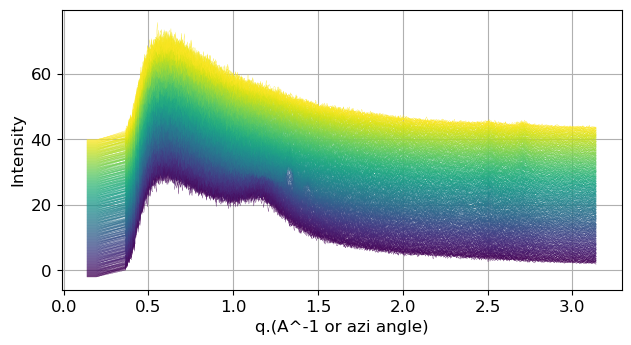

In [13]:
protocol = 'sector_average'
exp.plotWaterfall(key = protocol, y_spacing=0.07, lw=0.2, plot_xrange=np.arange(500))

In [ ]:
exp.plotHeatmap(key = protocol)

### B1.2 Get metadata

We can either extract metadata from the filename, or read from the databse. Currently it is easier to extract from filename if not working at the beamline. 

#### &#9673; Option 1) Extract 'metadata' from filename

In [ ]:
infiles = exp.dict['expinfo']['filename']
print('Number of files: {}'.format(len(infiles)))

sample_x = []
sample_y = []
scan_id = []
for ii, infile in enumerate(infiles):
    temp = infile.split('_')
    if ii==0: print(temp)
    sample_x.append(float(temp[-4][1:]))
    sample_y.append(float(temp[-3][1:]))
    scan_id.append(int(temp[-1]))

exp.dict['metadata']['sample_x'] = np.array(sample_x)
exp.dict['metadata']['sample_y'] = np.array(sample_y)
exp.dict['metadata']['scan_id'] = np.array(scan_id)

In [ ]:
if 0:  # For testing 
    print(infiles[0])
    temp = infiles[0].split('_')
    print(temp)
    x = float(temp[-4][1:])
    print(x)

#### &#9673; Option 2) Load metadata from h5 if available. Note this is for the selective dataset not complete database. DSSI is working on exporting the database.

In [ ]:
h5_path = EXPR_DIR+"/data/"
h5_file = 'B6_N3_Trans3_map_vac_x-1_metadata.h5'
exp.dict['metadata'] = h5todict(h5_path+h5_file)

#### &#9673; Option 3) [Currently only available at beamline workstation]  
&#9656; If you don't know the metadata you have/need:

In [14]:
if 1:  # Set to 1 if you don't know the metadata you have/need
    exp.listMetadata(verbosity=3)
    #exp.listMetadata(verbosity=-1) 

uid
time
calibration_wavelength_A
experiment_type
scan_id
experiment_group
experiment_project
experiment_cycle
calibration_energy_keV
experiment_proposal_number
beam_intensity_expected
platform_beam
experiment_SAF_number
experiment_alias_directory
experiment_user
plan_type
plan_name
detectors
num_points
num_intervals
plan_args
hints
sample_exposure_time
sample_measurement_ID
sample_savename_extra
sample_name
sample_clock
sample_temperature
sample_temperature_A
sample_temperature_B
sample_temperature_C
sample_temperature_D
sample_x
sample_motor_x
sample_y
sample_motor_y
sample_th
sample_motor_th
sample_savename
measure_type
series
detector_sequence_ID
beam_size_x_mm
beam_size_y_mm
beamline_mode
motor_SAXSx
motor_SAXSy
motor_WAXSx
motor_WAXSy
motor_WAXSz
motor_smx
motor_smy
motor_sth
motor_bsx
motor_bsy
motor_bsphi
measure_series_num_frames
filename
exposure_time


&#9656; Or specify the metadata directly

In [18]:
exp.dict['mdata_list'] = ['filename', 'scan_id', 'sample_x', 'sample_y'] # Load x and y positions for each measurement
exp.loadMetadata() 
exp.dict['metadata']

[0%] 
loadMetadata time = 0.0s


{'filename': ['PE_120C_fastscan_50V_30V_1mms_500pa_run1_x-0.002_y0.001_0.10s_630795.tiff'],
 'scan_id': [630795],
 'sample_x': [-0.001500000000000501],
 'sample_y': [0.0006500000000002615]}

&#9656; Save metadata (as h5) 

In [ ]:
h5_path = EXPR_DIR+"/data/"
h5_file = exp.samples[0]+'_metadata.h5'
dicttoh5(exp.dict['metadata'], h5_path+h5_file)
print(h5_path+h5_file)


In [20]:
#exp_df_md = pd.DataFrame.from_dict(exp.dict['metadata'])

## &#9632; B.2 Visualization

### B2.1 Plot 2D Color Image

#### For plotting mapping results, load the x and y positions from the metadata (specified and loaded in B1.2)

In [21]:
x_pos = exp.dict['metadata']['sample_x']
y_pos = exp.dict['metadata']['sample_y']
print('Len(y_pos) = {}'.format(len(y_pos)))

Len(y_pos) = 1


#### Load the analysis (reduced) data, e.g. load the linecut (of specific q) and define feature as the angle at which the peak max occurs, it can also be the max peak intensity, roi intensity etc. This section should be modified to output some 'feature' that you want to visualize its map.

&#9656; Example 1: load linecut and find the angle with max peak intensity

In [ ]:
reduced_data = exp.dict['data']['linecut_angle_fit']
print('Len(reduced_data) = {}'.format(len(reduced_data)))

feature_list = []
for ii in np.arange(0,len(reduced_data)):
    angle = reduced_data[ii]['angle']
    I = reduced_data[ii]['I']
    chi = angle[np.argmax(I)]
    feature_list.append(chi)


&#9656; Example 2: load roi

In [ ]:
reduced_data = exp.dict['data']['roi']
print('Len(reduced_data) = {}'.format(len(reduced_data)))
print(reduced_data.keys())

#reduced_data['stats_average'][0]

feature_list = []
for ii in np.arange(0,len(reduced_data)):
    feature_list.append(reduced_data['stats_average'][ii])

#### Plot option 1

In [ ]:
## If plot does not show up, enable this nbagg once and try again then disable
%matplotlib nbagg 

plt.figure(); plt.clf()

#plt.tripcolor(x_pos, y_pos, feature_list)  
plt.tricontourf(x_pos, y_pos, feature_list) 
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(exp.samples[0])
plt.axis('equal')
#plt.plot(x_pos, y_pos, 'w.')

#### Plot option 2

In [ ]:
## If plot does not show up, enable this nbagg once and try again then disable
#%matplotlib nbagg 

plot_interp = ['linear', 0.01] 
x_pos_fine, y_pos_fine, feature = Tools.interp_map(x_pos, y_pos, feature_list, plot_interp) 

plt.figure(); 
extent = (np.nanmin(x_pos_fine), np.nanmax(x_pos_fine), np.nanmin(y_pos_fine), np.nanmax(y_pos_fine))

plt.imshow(feature, extent=extent, origin='lower', cmap='jet', clim=[-180, 180])  
plt.colorbar()
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title(exp.samples[0])

#### Plot option 3 (Quiver plot)

In [ ]:
u_list = []
v_list = []
chi_list = []
for chi in feature_list:
    u = np.cos(np.deg2rad(chi)) 
    v = np.sin(np.deg2rad(chi)) 
    u_list.append(u)
    v_list.append(v)
    chi_list.append(chi)

In [ ]:
ax.quiver?

In [ ]:
fig, ax = plt.subplots(figsize=[8,6])

q = ax.quiver(x_pos, y_pos, u_list, v_list, chi_list, cmap = 'plasma') #,clim=[0,0.3])

#ax.set_xlim([-0.2,5])
#ax.set_ylim([-0.2,5])
ax.axis('equal')
ax.set_xlabel('$x$ (mm)')
ax.set_ylabel('$y$ (mm)')
cb = plt.colorbar(q)
plt.show()
plt.title(exp.samples[0])
# plt.savefig('SAXS mapping_quiver polt_colorbar.png', dpi = 600)



In [ ]:
exp.dict['data'].keys()

## &#9632; B.3 Export dictionary to h5

#### Save metadata to h5

In [ ]:
print(EXPR_DIR)
h5_path = EXPR_DIR+"/data/"
h5_file = 'metadata.h5'
dicttoh5(exp.dict, h5_path+h5_file)

In [ ]:
exp.dict['metadata']

#### Save experiment to h5

In [ ]:
print(EXPR_DIR)
h5_path = EXPR_DIR+"/data/"
h5_file = 'test.h5'
dicttoh5(exp.dict, h5_path+h5_file)

#### Read a h5 file to a python dictionary

Note that indices are load as strings, not full recovery from dict-->h5-->dict

In [ ]:
h5_path = EXPR_DIR+"/data/"
h5_file = 'test.h5'
test = h5todict(h5_path+h5_file)

In [ ]:
test

In [ ]:
#dicttoh5?

In [ ]:
# dicttoh5(exp.dict, "test.h5", h5path=EXPR_DIR+"/data/", mode = 'w')